In [1]:
# Start up Spark (only needs to be done once)
import pyspark.sql
session = pyspark.sql.SparkSession.builder \
    .master("mesos://zk://mesos-zk1:2181,mesos-zk2:2181,mesos-zk3:2181/mesos") \
    .appName("z-mumu") \
    .config('spark.driver.memory', '4g') \
    .config('spark.eventLog.enabled', 'true') \
    .config('spark.eventLog.dir', 'hdfs://hdfs-nn2/spark-history') \
    .config('spark.shuffle.service.enabled', 'true') \
    .config('spark.dynamicAllocation.enabled', 'false') \
    .config('spark.sql.catalogImplementation', 'in-memory') \
    .config('spark.mesos.executor.docker.image', 'perilousapricot/cms-jupyter:latest') \
    .config('spark.mesos.executor.home', '/usr/local/spark') \
    .config('spark.mesos.executor.docker.volumes', '/mnt/nfs/jupyter/:/home/:rw,/cvmfs:/cvmfs:ro,/lfs_roots/instances:/lio:rw,/cms:/cms:ro,/mnt/nfs/jupyter/passwd:/etc/passed:ro,/mnt/nfs/jupyter/group:/etc/group:ro,/tmp:/tmp') \
    .config('spark.executor.memory', '100g') \
    .config('spark.mesos.task.labels', 'testkey:testvalue') \
    .config('spark.dynamicAllocation.initialExecutors', '4') \
    .config('spark.dynamicAllocation.cachedExecutorIdleTimeout', '2h') \
    .config('spark.dynamicAllocation.executorIdleTimeout', '30m') \
    .config('spark.executor.cores', '14') \
    .config('spark.speculation', 'true') \
    .config('spark.mesos.executor.docker.parameters', 'workdir=/tmp') \
    .config('spark.executor.heartbeatInterval', '60s') \
    .config("spark.python.profile", "true") \
    .config('spark.jars.packages', 'org.diana-hep:spark-root_2.11:0.1.15,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .getOrCreate()
sc = session.sparkContext
sqlContext = session

In [2]:
import json
import sys
from pyspark.sql.functions import lit
from pyspark.sql.types import *

dataDFList = []
mcDFList = []

sys.stdout.write("\nLoading DataFrames ")
fileInputs = json.loads(open("input-files.json", "r").read())

for category, subcategory, path, xsec, efficiency, count in fileInputs: 
    if category in ("Category", "DISABLED"):
        continue
    
    dsPath = "hdfs://hdfs-nn2/tmp/store/group/ra2tau/" + path + "/"
    tempDF = sqlContext.read.load(dsPath) \
                    .withColumn("Category", lit(category)) \
                    .withColumn("SubCategory", lit(subcategory))

    if xsec == "DATA":
        tempDF2 = tempDF.withColumn("xsec", lit(float(1.0))) \
                        .withColumn("eff", lit(float(1.0))) \
                        .withColumn("count", lit(float(1.0)))
        dataDFList.append([tempDF2, category, subcategory, xsec, efficiency, count])
    else:
        tempDF2 = tempDF.withColumn("xsec", lit(float(xsec))) \
                        .withColumn("eff", lit(float(efficiency))) \
                        .withColumn("count", lit(float(count)))
        mcDFList.append([tempDF2, category, subcategory, xsec, efficiency, count])

    sys.stdout.write('.')
print "done"
# Monte-Carlo
if mcDFList:
    mcDF = mcDFList[0][0]
    print "%s(%s) - %s" % (mcDFList[0][1], mcDFList[0][2], mcDFList[0][0].count())
    for x in mcDFList[1:]:
        print "%s(%s) - %s" % (x[1], x[2], x[0].count())
        mcDF = mcDF.union(x[0])
    print "MC Partitions:  %d" % mcDF.rdd.getNumPartitions()

# Data
if dataDFList:
    dataDF = dataDFList[0][0]
    for x in dataDFList[1:]:
        dataDF = dataDF.union(x[0])
    print "Data Partitions: %d" % dataDF.rdd.getNumPartitions()


Loading DataFrames .......................done
DYJets(dy) - 48435266
DiBoson(ww) - 6947038
DiBoson(wz) - 2979124
DiBoson(zz) - 992744
SingleTop(ss) - 2876045
SingleTop(stb) - 3809631
SingleTop(stt) - 5964287
SingleTop(sttwb) - 991780
SingleTop(sttwt) - 985470
TTJets(tt) - 10066547
WJets(wj) - 29212279
WJets(wj) - 56246105
MC Partitions:  8355
Data Partitions: 10683


In [3]:
# Add a "weights" column
processedLumiPB = 35900
mcWeight = (mcDF['xsec'] * mcDF['eff'] * processedLumiPB) / mcDF['count']
mcDFWeighed = mcDF.withColumn("weight", mcWeight)
dataDFWeighed = dataDF.withColumn("weight", lit(1.0))

In [4]:
# We want to combine the data/MC into a single Spark dataset to simplify the
# later steps. To do this, though, they all need to have the same columns
reqCol = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_energy',
          'Muon_charge', 'Muon_loose',
          'Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_energy',
          'Met_type1PF_pt','Met_type1PF_px','Met_type1PF_py',
          'Met_type1PF_pz','Met_type1PF_phi',
          'eff', 'xsec', 'weight',
          'Category', 'SubCategory']
trimMCDF = mcDFWeighed.select(*reqCol)
trimDataDF = dataDFWeighed.select(*reqCol)
trimDF = trimMCDF.union(trimDataDF)

In [5]:
# Define a custom spark type. This type will be added to a custom
# column which is an output from a python function
from pyspark.sql.types import *

muSchema = StructType([
    # Simple flags
    StructField("pass", BooleanType(), False),
    StructField("ss", BooleanType(), False),
    StructField("invmass", FloatType(), False),

    # Properties of muons that pass our cuts
    StructField("pt1", FloatType(), False),
    StructField("eta1", FloatType(), False),
    StructField("phi1", FloatType(), False),
    StructField("energy1", FloatType(), False),
    StructField("charge1", FloatType(), False),
    
    StructField("pt2", FloatType(), False),
    StructField("eta2", FloatType(), False),
    StructField("phi2", FloatType(), False),
    StructField("energy2", FloatType(), False),
    StructField("charge2", FloatType(), False),
])

In [6]:
# Define a custom python function which will produce some derived values. This
# can be absolutely anything, as long as its deterministic and idempotent

# ... The will be of the type we defined just before.
muonTestFalse = (False, False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
def muonTest(pt,eta,phi,energy,charge,loose):
    """
    Perform muon selection:
      pT > 30
      abs(eta) < 2.1
      80GeV < DiMuonInvMass < 100GeV
      N(mu) == 2
    """
    passes = True
    if len(pt) < 2:
        return muonTestFalse
    
    leadingIdx = None
    trailingIdx = None
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and loose[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and loose[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 30 and abs(eta[idx]) < 2.1 and loose[idx]:
                return muonTestFalse
    
    if leadingIdx != None and trailingIdx != None:
        dimuInvMass = invMass(pt[leadingIdx], pt[trailingIdx],
                                eta[leadingIdx], eta[trailingIdx],
                                phi[leadingIdx], phi[trailingIdx],
                                energy[leadingIdx], energy[trailingIdx])
        return (True,
                (charge[leadingIdx] * charge[trailingIdx]) > 0,
                dimuInvMass,
                pt[leadingIdx], pt[trailingIdx],
                eta[leadingIdx], eta[trailingIdx],
                phi[leadingIdx], phi[trailingIdx],
                energy[leadingIdx], energy[trailingIdx],
                charge[leadingIdx], charge[trailingIdx])
    else:
        # if N(mu) != 2
        return muonTestFalse

import math
def invMass(pt0,pt1, eta0, eta1, phi0, phi1, energy0, energy1):
    vec1 = (pt0 * math.cos(phi0), pt0 * math.sin(phi0), pt0 * math.sinh(eta0), energy0)
    vec2 = (pt1 * math.cos(phi1), pt1 * math.sin(phi1), pt1 * math.sinh(eta1), energy1)

    sumvec = (vec1[0] + vec2[0],
              vec1[1] + vec2[1],
              vec1[2] + vec2[2],
              vec1[3] + vec2[3])
    magSquared = sumvec[0]*sumvec[0] \
                     + sumvec[1]*sumvec[1] \
                     + sumvec[2]*sumvec[2] \
                     - sumvec[3]*sumvec[3]
    if magSquared > 0.0:
        return math.sqrt(magSquared)
    else:
        return math.sqrt(-magSquared)

In [7]:
# Convert the python function to a Spark UDF (there's also a
# decorator that does this). This tells Spark to run muonTest
# and return muSchema
from pyspark.sql.functions import udf
muonUDF = udf(muonTest, muSchema)

# Now tell Spark we want to 
flatDF = trimDF.withColumn("muSel", muonUDF("Muon_pt", 
                                           "Muon_eta",
                                           "Muon_phi",
                                           "Muon_energy",
                                           "Muon_charge",
                                           "Muon_loose"))

In [8]:
passMuDF = flatDF.where("muSel.pass == True")
passMuDF = passMuDF.cache()

In [9]:
passMuDF.where("muSel.ss == True").select('muSel').show(truncate = False)


+--------------------------------------------------------------------------------------------------------------------+
|muSel                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------+
|[true,true,42.130745,70.31298,37.222256,0.12262728,-0.6786659,-0.02368905,-0.05557488,70.842384,46.128536,-1.0,-1.0]|
|[true,true,83.21503,51.00024,31.819628,0.9399291,1.5536748,-1.5349883,1.9570378,75.237045,78.59909,-1.0,-1.0]       |
|[true,true,150.14207,129.67409,33.094105,0.38001454,-0.6884529,-0.6914861,2.489376,139.15054,41.251705,-1.0,-1.0]   |
|[true,true,146.35324,102.219955,45.875477,-0.16423549,0.6313914,-0.48854694,2.969861,103.601715,55.327675,1.0,1.0]  |
|[true,true,0.9542496,56.914436,31.983658,1.1955177,1.1925913,-0.86010593,-0.88167036,102.66845,57.555393,-1.0,-1.0] |
|[true,true,90.15616,62.719593,32.472797,0.95021

In [10]:
# Load libraries, amp up passMuDF with histogrammar
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql
hg.sparksql.addMethods(passMuDF)

In [11]:
# Monkey-patch histogrammar to fix a bug
def x(self, jvm, converter):
    return converter.Select(self.quantity.asSparkSQL(), self.cut._sparksql(jvm, converter))
hg.Select._sparksql = x

In [12]:
plots = hg.UntypedLabel(
    # Count events (both raw and weighted)
    nRawEvents = hg.Sum(lit(1.0)),
    nEvents = hg.Sum(passMuDF['weight']),
    # Make some regular "histograms" of muon pT
    LeadPt = hg.Bin(50, 0, 150, passMuDF['muSel.pt1'], hg.Count(passMuDF['weight'])),
    SecondPt = hg.Bin(50, 0, 150, passMuDF['muSel.pt2'], hg.Count(passMuDF['weight'])),
    # Let's make an additional cut for only same-sign events
    ssCut = hg.Select(
        passMuDF['muSel.ss'] == True,
        # .. and count them
        hg.Sum(passMuDF['weight']),
    ),
)     

In [13]:
# Make a set of histograms per-sample
bulkHisto = hg.Categorize(quantity = passMuDF["Category"], value = plots)

In [14]:
# Fill from spark -- this is needed if you do a hg.Categorize (static) instead of a passMuDF.Categorize (the class method)
bulkHisto.fillsparksql(df=passMuDF)

In [15]:
# Output some event counts as a result of cuts
# ... something is off with my WJets input files
sumEvents = 0.0
sumRawEvents = 0.0
print "Sample  Raw  Weighted"
for sample in bulkHisto.bins:
    if sample == "SingleMuon":
        continue
    events = bulkHisto(sample)('nEvents').sum
    rawEvents = bulkHisto(sample)('nRawEvents').sum
    print "%11s   %9.1f  % 11.1f" % (sample, rawEvents, events)
    sumEvents += float(events)
    sumRawEvents += float(rawEvents)

print "=" * 36
print "    Sum(MC)  % 9.1f  % 11.1f" % (sumRawEvents, sumEvents)
print "       Data % 9.1f  % 11.1f" % (bulkHisto('SingleMuon')('nRawEvents').sum, bulkHisto('SingleMuon')('nEvents').sum)

Sample  Raw  Weighted
    DiBoson     71586.0      22699.2
     TTJets     88222.0     261691.0
      WJets      3238.0      83691.0
     DYJets   3974396.0   15693668.7
  SingleTop     28587.0      27169.3
    Sum(MC)   4166029.0   16088919.3
       Data  18207696.0   18207696.0


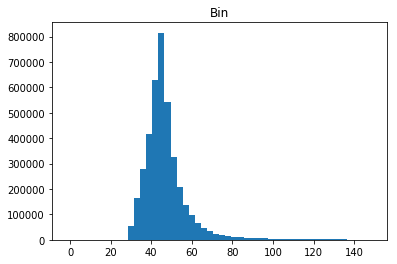

In [16]:
bulkHisto('DYJets')('LeadPt').plot.matplotlib()

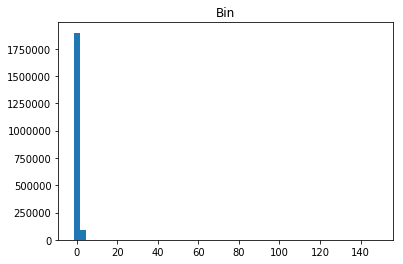

In [17]:
bulkHisto('DYJets')('SecondPt').plot.matplotlib()

If you would like access to Vanderbilt's Spark cluster (with access to these datasets), contact Andrew Melo

In [18]:
import numpy as np

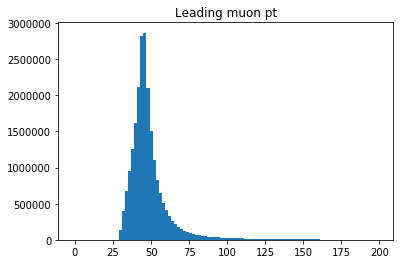

In [19]:
h1 = passMuDF.Bin(100, 0, 200, passMuDF['muSel.pt1'])
ax = h1.plot.matplotlib(name="Leading muon pt")

In [20]:
print h1.__dict__
print bulkHisto('DYJets')('LeadPt').__dict__

{'plot': <histogrammar.util.PlotMethod object at 0x596fed0>, 'nanflow': <Count 0.0>, '_checkedForCrossReferences': False, 'underflow': <Count 0.0>, 'high': 200.0, 'values': [<Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 0.0>, <Count 134293.0>, <Count 404043.0>, <Count 674315.0>, <Count 949888.0>, <Count 1252243.0>, <Count 1613596.0>, <Count 2108791.0>, <Count 2826722.0>, <Count 2866933.0>, <Count 2103426.0>, <Count 1502237.0>, <Count 1101942.0>, <Count 833469.0>, <Count 645576.0>, <Count 510146.0>, <Count 406379.0>, <Count 328717.0>, <Count 266987.0>, <Count 215985.0>, <Count 175730.0>, <Count 144474.0>, <Count 121096.0>, <Count 102361.0>, <Count 89062.0>, <Count 78551.0>, <Count 69318.0>, <Count 61972.0>, <Count 55745.0>, <Count 50076.0>, <Count 45256.0>, <Count 41292.0>, <Count 38015.0>, <Count 34505.0>, <Count 31820.0>, <Count 29450.0>, <Coun